verificare se ci sono dei grafici migliori per rappresentare le mie informazioni

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.stats.power import TTestIndPower
import seaborn as sns
from scipy.stats import linregress

In [3]:
# necessario creare una cartella dati fuori da questa
magistrale= pd.DataFrame(pd.read_excel("../dati/iscritti_magistrale_informatica.xls")) 
triennale= pd.DataFrame(pd.read_excel("../dati/iscritti_triennale_informatica.xls")) 
piani= pd.DataFrame(pd.read_excel("../dati/piani_informatica.xls"))

In [4]:
piani.head()

,PROGRESSIVO,CODCLA,CODICE_INS,DECODIFICA_INS,CFU,DATA_ESAME,VOTO,DESCRIZIONE_VOTO
0,79842,8759,102406,LINGUA INGLESE 1,3.0,2023-11-15,32,idoneo
1,79842,8759,67866,PROVA FINALE (INDIRIZZO PROPEDEUTICO),3.0,2023-12-14,45,superato
2,90157,8759,57069,CALCULUS 1,6.0,2013-01-23,19,diciannove
3,90157,8759,61802,ISTITUZIONI DI PROTOCOLLI E RETI,7.0,2011-09-21,28,ventotto
4,90157,8759,61799,LINGUAGGI E PROGRAMMAZIONE ORIENTATA AGLI OGG...,12.0,2013-09-13,20,venti


In [5]:
# verifico di avere un campione sufficiente all'analisi

Z = 1.96  # Livello di confidenza del 95%
sigma = 10  # Deviazione standard stimata
E = 2  # Margine di errore desiderato

# Calcolo della dimensione del campione
n = (Z * sigma / E) ** 2
n = math.ceil(n)  # Arrotonda per eccesso al numero intero più vicino

print(f"Dimensione del campione necessaria: {n}")

Dimensione del campione necessaria: 97


In [6]:
# percentuale donne in triennale: 14.4
print((triennale['GENERE'] == 'F').mean() * 100)

14.436363636363636


In [7]:
# join triennale
pt = pd.merge(piani, 
              triennale[['PROGRESSIVO', 'CODCLA', 'GENERE', 'ANAC_INGRESSO', 'ANAC_USCITA','DATA_LAUREA','SITUAZIONE_FINALE','VOTO_LAUREA']], 
              how="right", 
              left_on=["PROGRESSIVO", "CODCLA"], 
              right_on=["PROGRESSIVO", "CODCLA"])

In [8]:
# pulizia dati

# elimino in piani_triennali i valori in cui ho NaN in CODICE_INS e DECODIFICA_INS
pt.dropna(subset=['CODICE_INS', 'DECODIFICA_INS'], how='all', inplace=True)

# miglioro leggibilità
pt['CODCLA'] = pt['CODCLA'].astype(int)
pt['CODICE_INS'] = pt['CODICE_INS'].astype(int)
pt['VOTO'] = pt['VOTO'].astype(int)

# elimino colonna rindondante (codcla separa triennale e magistrale)
pt['CODCLA'].unique()
pt.drop(columns=['CODCLA'], inplace=True)

# elimino insegnamenti con meno di 50 partecipanti (molti a scelta con solo 1 persona)
pt = pt[pt.groupby('DECODIFICA_INS')['PROGRESSIVO'].transform('size') >= 50] # -- osservare cambiamenti al variare di min

# non ho voti inferiori al 18 -- notificare
#print(pt['VOTO'].min())

# elimino i voti maggiori di 32 - perchè non so cosa siano, per ora --notificare
pt = pt[pt['VOTO'] <= 32]

A cosa si riferiscono i voti maggiori di 32?

In [9]:
# per ogni esame passato percentuale di donne

# numero studenti
n_studenti = pt['PROGRESSIVO'].nunique()
# numero studenti per esame
n_studenti_per_esame = pt.groupby('DECODIFICA_INS').size()
# percentuale studenti per esame, su quelli nel database
perc = (n_studenti_per_esame / n_studenti) *100
# percentuale donne per esame
n_donne_per_esame = pt[pt['GENERE'] == 'F'].groupby('DECODIFICA_INS').size()
perc_donne = ((n_donne_per_esame / n_studenti_per_esame) * 100)#.astype(int)


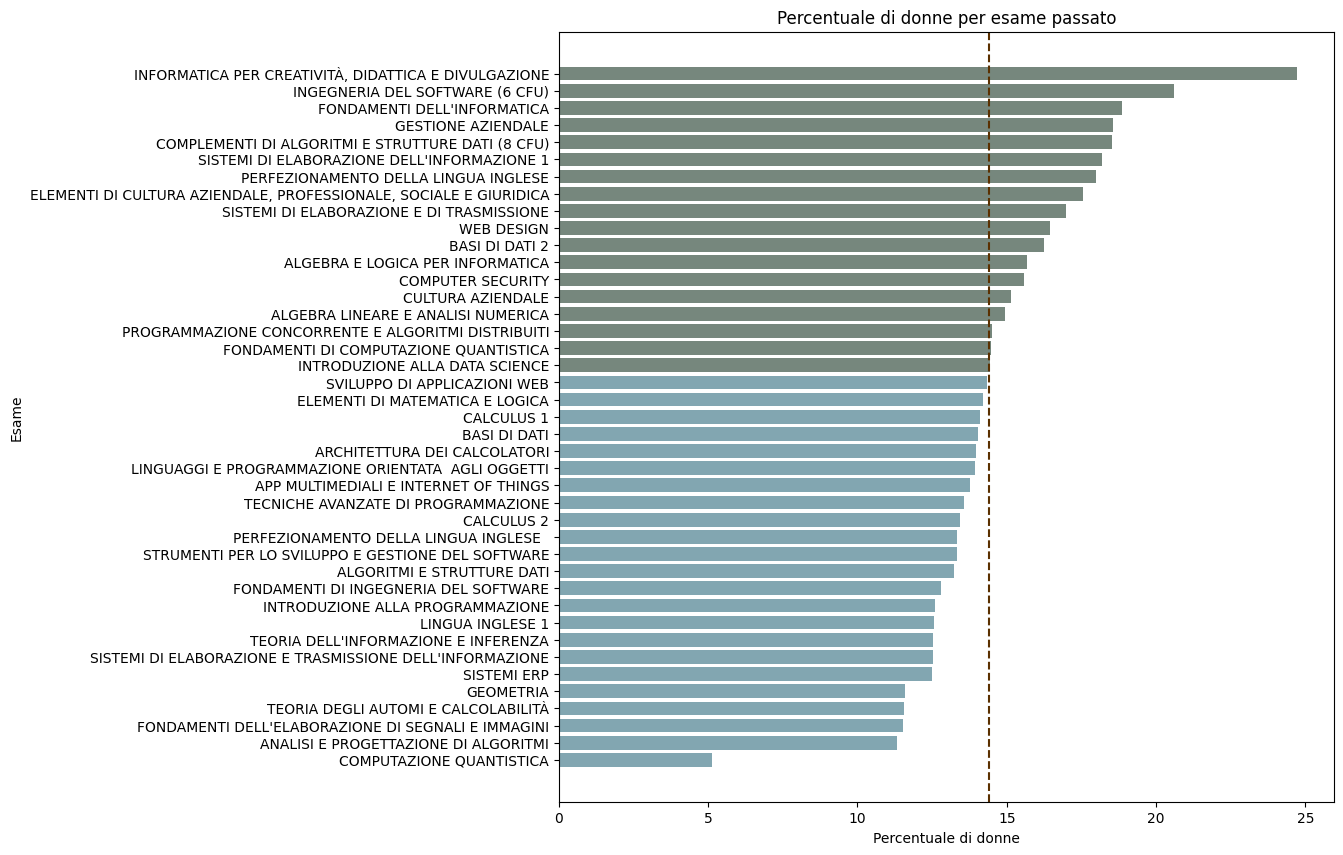

In [10]:
# visualizzazione percentuale di donne sul numero totale, di persone che hanno superato l'esame

perc_donne_sorted = perc_donne.sort_values()
colors = ['#82A6B1' if val < 14.4 else '#76877D' for val in perc_donne_sorted]
plt.figure(figsize=(10, 10))
bars = plt.barh(perc_donne_sorted.index, perc_donne_sorted, color=colors)
plt.axvline(x=14.4, color='#5B3000', linestyle='--')
plt.xlabel('Percentuale di donne')
plt.ylabel('Esame')
plt.title('Percentuale di donne per esame passato')
plt.show()

### percentuale di donne sul numero totale, di persone che hanno superato l'esame

Il numero di donne in questo database è il 14,4%, uso questo dato come soglia <br>
Osservo che esistono esami in favore e sfavore di entrambi i sessi, non posso assumere molto <br>

In [11]:
# la percentuale esami passati
totale_voti = len(pt)  # non ci sono null #print(pt['CODICE_INS'].isnull().sum()) #print(pt['VOTO'].isnull().sum())
totale_voti_donne = len(pt[pt['GENERE'] == 'F']) 
(totale_voti_donne/totale_voti)*100

13.846869909239004

### percentuale del numero di voti delle donne rispetto agli uomini
percentuale di voti leggermente più bassa del numero di donne, posso assumere che si fermino prima degli uomini nel percorso?

In [12]:
# colori grafici
#colore_donne = '#F1C40F'
#colore_uomini = '#EF5B5B'

colore_donne = '#1ED074'
colore_uomini = '#FFA22E'

In [13]:
# analizzo l'andamento generale dei voti per ogni esame (solo chi ha passato l'esame)
perc_voti = ((pt.groupby('VOTO').size()) / (totale_voti)) * 100

In [14]:
# analizzo l'andamento per le donne dei voti
perc_voti_donne = ((pt[pt['GENERE'] == 'F'].groupby('VOTO').size()) / (totale_voti_donne)) * 100

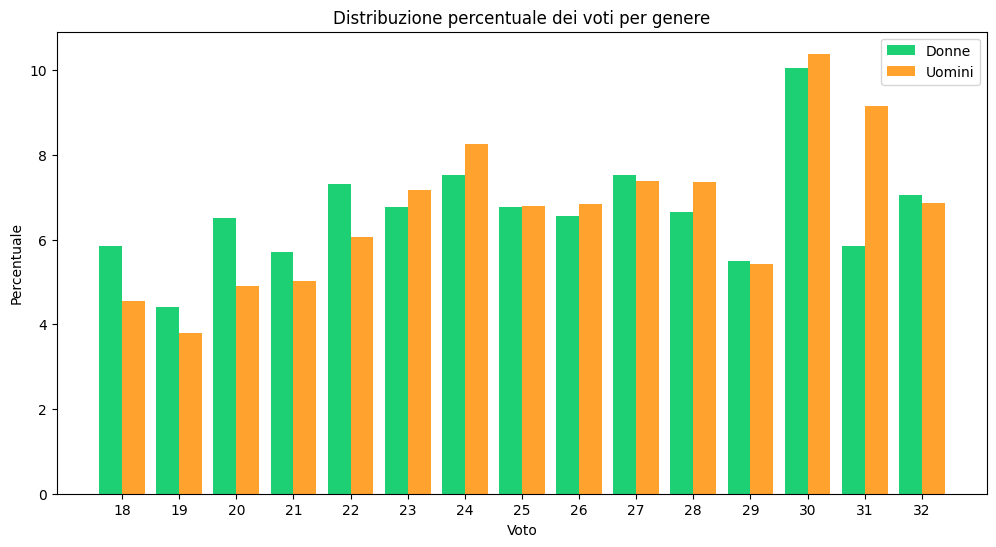

In [15]:
# visualizzazione della percentuale dei voti per genere

totale_voti_donne = len(pt[pt['GENERE'] == 'F'])
totale_voti_uomini = len(pt[pt['GENERE'] == 'M'])
voti_donne = pt[pt['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = pt[pt['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


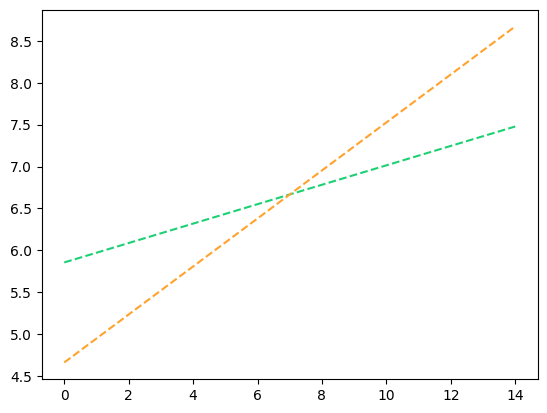

In [16]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini

plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')


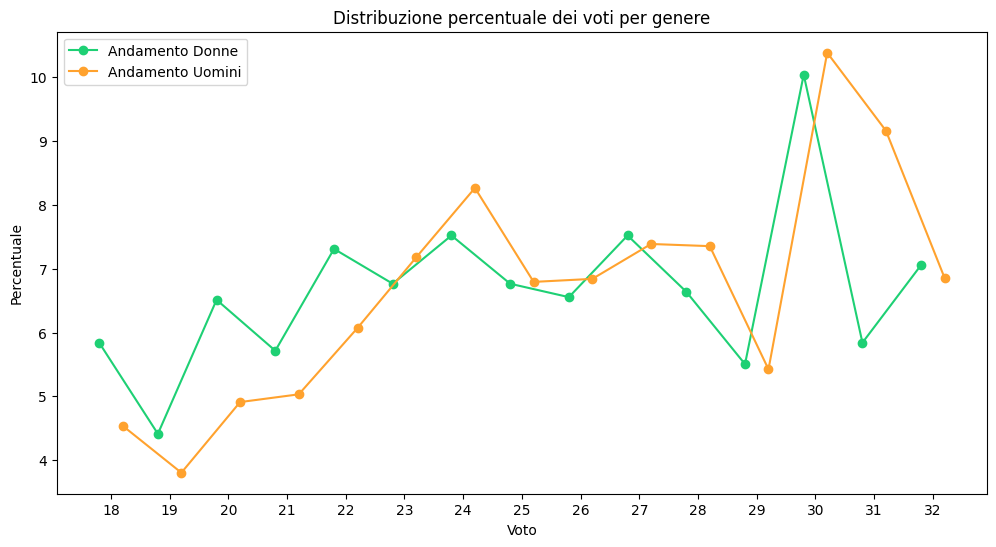

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(r1, percentuale_voti_donne, marker='o', color=colore_donne, label='Andamento Donne')
plt.plot(r2, percentuale_voti_uomini, marker='o', color=colore_uomini, label='Andamento Uomini')
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.legend()
plt.show()

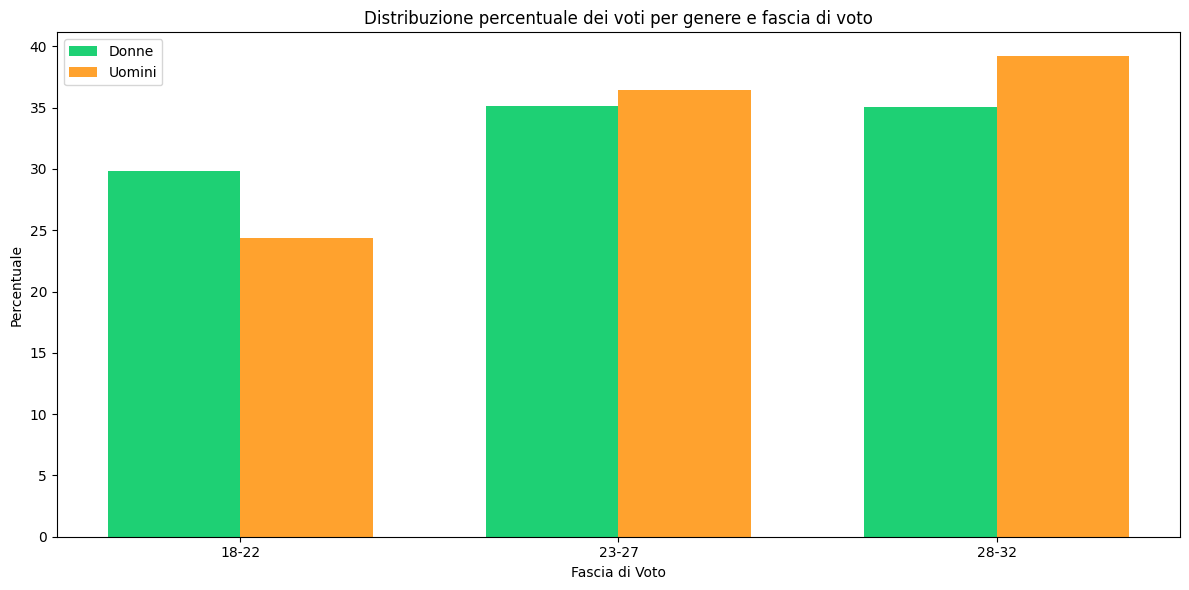

In [18]:
def categorize_voto(voto):
    if voto >= 18 and voto <= 22:
        return '18-22'
    elif voto >= 23 and voto <= 27:
        return '23-27'
    elif voto >= 28 and voto <= 32:
        return '28-32'
    else:
        return 'Altro'

pt['FASCIA_VOTO'] = pt['VOTO'].apply(categorize_voto)
totale_voti = pt.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


### Percentuale di voti per ogni esame, divisi per genere
Osservo che le donne prediligono voti inferiori rispetto agli uomini

In [19]:
pt.head()

,PROGRESSIVO,CODICE_INS,DECODIFICA_INS,CFU,DATA_ESAME,VOTO,DESCRIZIONE_VOTO,GENERE,ANAC_INGRESSO,ANAC_USCITA,DATA_LAUREA,SITUAZIONE_FINALE,VOTO_LAUREA,FASCIA_VOTO
2,148682,80298,ALGORITMI E STRUTTURE DATI,12.0,2014-07-30,27,ventisette,M,2013,2018,2019-07-24,ATTIVO,111.0,23-27
3,148682,67425,ARCHITETTURA DEI CALCOLATORI,12.0,2014-09-26,30,trenta,M,2013,2018,2019-07-24,ATTIVO,111.0,28-32
4,148682,57069,CALCULUS 1,6.0,2016-09-15,30,trenta,M,2013,2018,2019-07-24,ATTIVO,111.0,28-32
5,148682,80299,INTRODUZIONE ALLA PROGRAMMAZIONE,12.0,2014-04-10,29,ventinove,M,2013,2018,2019-07-24,ATTIVO,111.0,28-32
6,148682,73026,ELEMENTI DI MATEMATICA E LOGICA,12.0,2016-02-09,28,ventotto,M,2013,2018,2019-07-24,ATTIVO,111.0,28-32


In [20]:
def categorizza(row):
    if pd.notnull(row['DATA_LAUREA']):
        return 'laurea'
    elif (row['SITUAZIONE_FINALE'] == 'BLOCCO CARRIERA PER MANCATO PAGAMENTO (CC/VIRTUALE)') or \
         (row['SITUAZIONE_FINALE'] == 'ISCRIZIONE NON ATTIVA PER CARRIERA APERTA') or \
         (row['SITUAZIONE_FINALE'] == 'RINUNCIATARIO') or \
         (row['SITUAZIONE_FINALE'] == 'CONGEDATO') or \
         (row['SITUAZIONE_FINALE'] == 'INTERRUZIONE DEGLI STUDI') or \
         (row['SITUAZIONE_FINALE'] == 'SOSPESO RISERVA MOB.INT.'):
        return 'non laurea'
    elif (row['SITUAZIONE_FINALE'] == 'ATTIVO') or \
         (row['SITUAZIONE_FINALE'] == 'MANCATO PAGAMENTO I/II RATA ') or \
         (row['SITUAZIONE_FINALE'] == 'ANNO DI CORSO SOTTO CONDIZIONE'):
        return 'in esecuzione'
    else:
        return 'non laurea'

pt_laurea = pt.copy()
pt_laurea['CATEGORIA'] = pt_laurea.apply(categorizza, axis=1)

In [21]:
# analizzo il numero di donne laureate

print("Ricordiamo che la percentuale di donne è il 14%")

n_donne_laurea = pt_laurea[(pt_laurea['GENERE'] == 'F') & (pt_laurea['CATEGORIA'] == 'laurea')]
n_uomini_laurea = pt_laurea[(pt_laurea['GENERE'] == 'M') & (pt_laurea['CATEGORIA'] == 'laurea')]
n_laurea = len(n_donne_laurea)+len(n_uomini_laurea)
perc_laurea = int((len(n_donne_laurea) / n_laurea) * 100)
print(f"Percentuale donne laureate sul totale dei laureati: {perc_laurea}%")

n_donne_non_laurea = pt_laurea[(pt_laurea['GENERE'] == 'F') & (pt_laurea['CATEGORIA'] == 'non laurea')]
n_uomini_non_laurea = pt_laurea[(pt_laurea['GENERE'] == 'M') & (pt_laurea['CATEGORIA'] == 'non laurea')]
n_non_laurea = len(n_donne_non_laurea)+len(n_uomini_non_laurea)
perc_non_laurea = int((len(n_donne_non_laurea) / n_non_laurea) * 100)
print(f"Percentuale donne non laureate sul totale dei non laureati: {perc_non_laurea}%")

Ricordiamo che la percentuale di donne è il 14%
Percentuale donne laureate sul totale dei laureati: 12%
Percentuale donne non laureate sul totale dei non laureati: 9%


### Periodo preciso, pandemia
analizzo un periodo temporale preciso, il periodo di pandemia, in cui le modalità di esame sono cambiate per tutti gli insegnamenti <br>
inizio: 11 marzo 2020 <br>
non ho una data precisa della fine del periodo, perchè dipende dall'università, dal dipartimento e dal singolo professore <br>
indicativamente le sessioni con modalità d'esame completamente online sono state quelle estive giugno, luglio, settemrbe) del 2020 e quella invernale (gennaio, febbraio) del 2021 <br>
questo per quanto riguarda il dipartimento di informatica, <br>
successivamente alcuni professori hanno mantenuto alcune modalità online, come quiz o orali

In [22]:
# periodo pandemia : marzo 2020 - marzo 2021

data_inizio = '2020-03-11' #anno-mese-giorno
data_fine = '2021-03-11'
periodo_pandemia = pt[pt['DATA_ESAME'].between(data_inizio, data_fine)]

NON_periodo_pandemia = pt[~pt['DATA_ESAME'].between(data_inizio, data_fine)]

In [23]:
media_voti = round(pt['VOTO'].mean(), 2)
media_voti_p_p = round(periodo_pandemia['VOTO'].mean(), 2)
media_voti_N_p_p = round(NON_periodo_pandemia['VOTO'].mean(), 2)

print(f"Media valutazioni: {media_voti}")
print(f"Media valutazioni periodo di pandemia: {media_voti_p_p}")
print(f"Media valutazioni escluso il periodo di pandemia: {media_voti_N_p_p}")


Media valutazioni: 25.74
Media valutazioni periodo di pandemia: 25.75
Media valutazioni escluso il periodo di pandemia: 25.73


Le medie si discostanoin modo NON significativo nei diversi periodi

In [24]:
donne = pt[pt['GENERE'] == 'F']
uomini = pt[pt['GENERE'] == 'M']

donne_p_p = periodo_pandemia[periodo_pandemia['GENERE'] == 'F']
uomini_p_p = periodo_pandemia[periodo_pandemia['GENERE'] == 'M']

print("Media valutazioni")
media_voti = round(donne['VOTO'].mean(), 2)
print(f"Donne: {media_voti}")
media_voti = round(uomini['VOTO'].mean(), 2)
print(f"Uomini: {media_voti}")
print()
print("Media valutazioni periodo di pandemia")
media_voti_p_p = round(donne_p_p['VOTO'].mean(), 2)
print(f"Donne: {media_voti_p_p}")
media_voti_p_p = round(uomini_p_p['VOTO'].mean(), 2)
print(f"Uomini: {media_voti_p_p}")

Media valutazioni
Donne: 25.32
Uomini: 25.8

Media valutazioni periodo di pandemia
Donne: 25.33
Uomini: 25.81


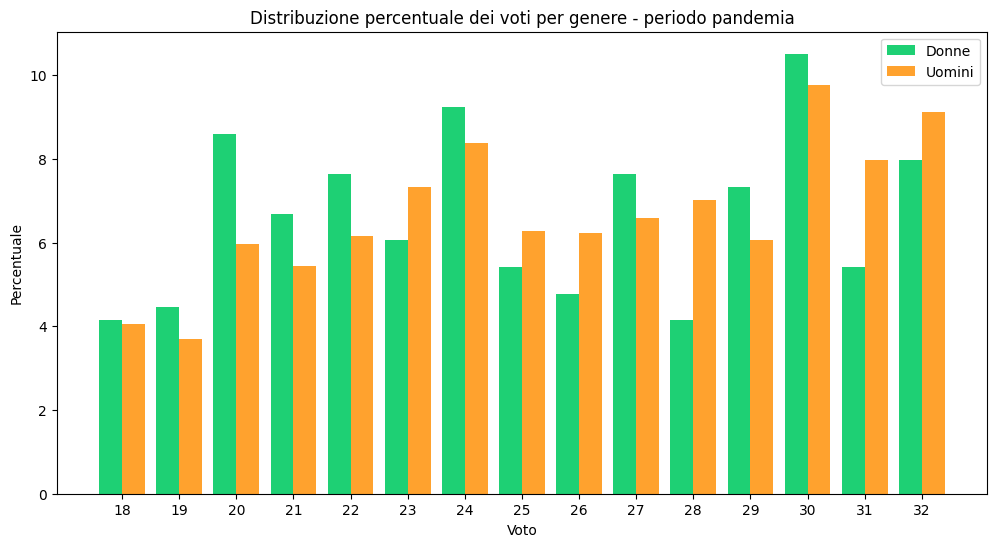

In [25]:
totale_voti_donne = len(periodo_pandemia[periodo_pandemia['GENERE'] == 'F'])
totale_voti_uomini = len(periodo_pandemia[periodo_pandemia['GENERE'] == 'M'])
voti_donne = periodo_pandemia[periodo_pandemia['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = periodo_pandemia[periodo_pandemia['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color= colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere - periodo pandemia')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


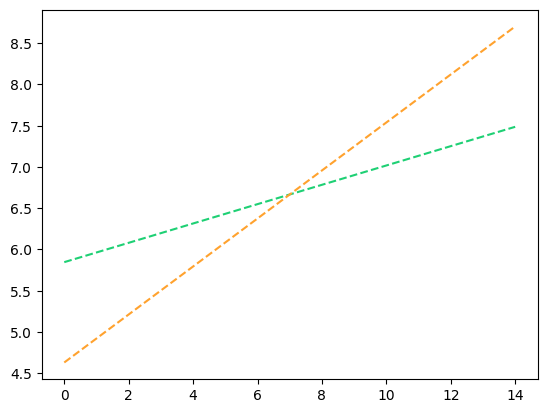

In [26]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini

plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')


### Il periodo di pandemia ha inciso in generale sui singoli voti
In generale è aumentato il divario di genere guardando singolarmente i voti <br>
L'andamento degli uomini è cambiato meno rispetto a quello delle donne <br> -- non so se posso affermarlo stando a questi dati
per le donne sono diminuiti i 18 e aumentati i 20, 22, 24 <br>
Per gli uomini sono aumentati i 32 <br>

In generale le valutazioni si sono alzate, ma la media è rimasta costante
Questi risultati possono essere dati dalla scarsità del campione per quanto riguarda le donne

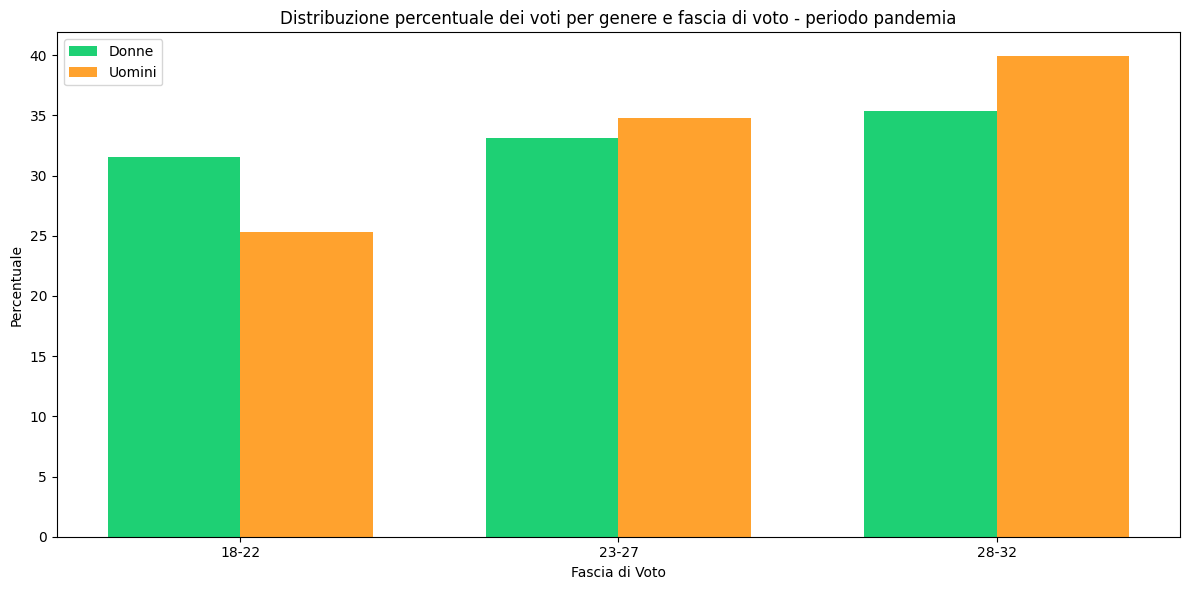

In [27]:
totale_voti = periodo_pandemia.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto - periodo pandemia')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()

raggruppando per fasce di voti, non è cambiato l'andamento nel periodo di pandemia <br>

### ESAMI TRIENNALE
IP: diverse fasi <br>
<b>Algebra e logica</b>: 2 scritti <br>
ADC: solo orale, ma cambiata modalità <br>
ASD: diverse fasi <br>
CALCULUS1 : diverse fasi <br>
LPOO: diverse fasi <br>
<b>SETI</b>: quiz sbarramento + orale <br>
BD: diverse fasi <br>
<b>ALAN</b>: due scritti <br>
<b>TDII</b>: solo scritto <br>
<b>APA</b>: scritto sbarramento + orale di 2 professori <br>
<b>CALCULUS2</b>: solo scritto <br>
<b>SAW</b>:  domande sbarramento + orale progetto <br>
<b>CS</b>: solo scritto <br>
<b>PCAD</b>: solo scritto<br>
<b>TAC</b>: scritto sbarramento + orale <br>
<b>FIS</b>: quiz sbarramento + due scritti <br>
<b>FCQ</b>: solo orale <br>
TAP: diverse fasi <br>
<br>
FESI: diverse fasi <br>
ICDD:  <br>
IDS: diverse fasi <br>
AMEIOT: <br>
MPPA: <br>
SSGS: <br>
WD: <br>
<br>
Alcuni esami, facendo progetti durante l'anno possono aumentare il voto finale

DA VERIFICARE CHE LE MODALITA NON SIANO CAMBIATE DURANTE GLI ANNI

### Analizzo singolarmente alcuni insegnamenti con una sola modalità di esame
per ora assumo che anche i vecchi insegnamenti avessero le modalità riportate<br>
<br>
Esami orali: 
<br>
<b>SETI</b>: quiz sbarramento + orale <br>
<b>APA</b>: scritto sbarramento + orale di 2 professori <br>
<b>SAW</b>:  domande sbarramento + orale progetto <br>
<b>TAC</b>: scritto sbarramento + orale <br>
<b>FCQ</b>: solo orale <br>


<br>
Esami scritti: <br>
<b>Algebra e logica</b>: 2 scritti <br>
<b>ALAN</b>: due scritti <br>
<b>TDII</b>: solo scritto <br>
<b>CALCULUS2</b>: solo scritto <br>
<b>CS</b>: solo scritto <br>
<b>PCAD</b>: solo scritto<br>
<b>FIS</b>: quiz sbarramento + due scritti <br>


In [28]:
# Osservo gli esami orali con modalità di esame simili

esami_orali = pt[(pt['DECODIFICA_INS'] == "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE") |
                 (pt['DECODIFICA_INS'] == "ANALISI E PROGETTAZIONE DI ALGORITMI") |
                 (pt['DECODIFICA_INS'] == "SVILUPPO DI APPLICAZIONI WEB") |
                 (pt['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA") |
                 (pt['DECODIFICA_INS'] == "FONDAMENTI DI COMPUTAZIONE QUANTISTICA")]


In [29]:
# Osservo gli esami scritti con modalità di esame simile

esami_scritti = pt[(pt['DECODIFICA_INS'] == "ALGEBRA E LOGICA PER INFORMATICA") |
                 (pt['DECODIFICA_INS'] == "ALGEBRA LINEARE E ANALISI NUMERICA") |
                 (pt['DECODIFICA_INS'] == "TEORIA DELL'INFORMAZIONE E INFERENZA") |
                 (pt['DECODIFICA_INS'] == "CALCULUS 2") |
                 (pt['DECODIFICA_INS'] == "COMPUTER SECURITY") |
                 (pt['DECODIFICA_INS'] == "PROGRAMMAZIONE CONCORRENTE E ALGORITMI DISTRIBUITI") |
                 (pt['DECODIFICA_INS'] == "FONDAMENTI DI INGEGNERIA DEL SOFTWARE")]

In [30]:
# orali
media_orali = round(esami_orali['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali: {media_orali}")

donne = esami_orali[esami_orali['GENERE'] == 'F']
media_orali = round(donne['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali delle donne: {media_orali}")

uomini = esami_orali[esami_orali['GENERE'] == 'M']
media_orali = round(uomini['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali degli uomini: {media_orali}")

# scritti
media_scritti = round(esami_scritti['VOTO'].mean(), 2)
print(f"Media valutazioni esami scritti: {media_scritti}")

donne = esami_scritti[esami_scritti['GENERE'] == 'F']
media_orali = round(donne['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali delle donne: {media_orali}")

uomini = esami_scritti[esami_scritti['GENERE'] == 'M']
media_orali = round(uomini['VOTO'].mean(), 2)
print(f"Media valutazioni esami orali degli uomini: {media_orali}")

Media valutazioni esami orali: 25.82
Media valutazioni esami orali delle donne: 25.58
Media valutazioni esami orali degli uomini: 25.85
Media valutazioni esami scritti: 24.16
Media valutazioni esami orali delle donne: 23.61
Media valutazioni esami orali degli uomini: 24.25


/tmp/ipykernel_3896/2456426605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esami_scritti['TIPO_ESAME'] = 'SCRITTI'
/tmp/ipykernel_3896/2456426605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esami_orali['TIPO_ESAME'] = 'ORALI'


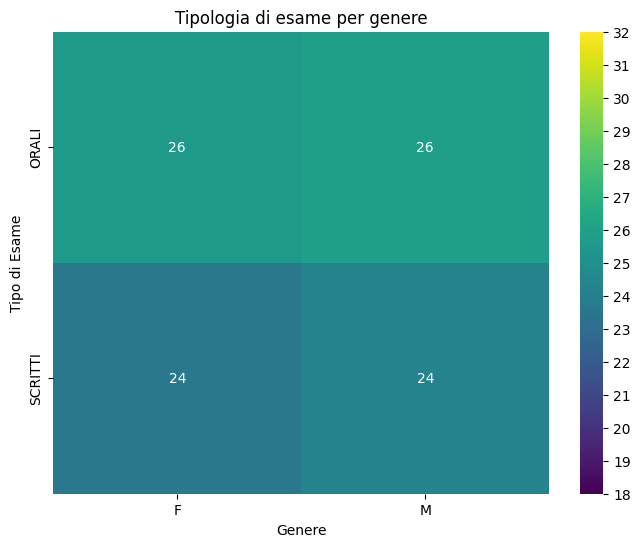

In [31]:
# creo nuovo db esami per non gestire null
esami_scritti['TIPO_ESAME'] = 'SCRITTI'
esami_orali['TIPO_ESAME'] = 'ORALI'
esami = pd.concat([esami_scritti, esami_orali])

pivot_table = esami.pivot_table(values='VOTO', index='TIPO_ESAME', columns='GENERE', aggfunc='mean')
cbar_kws = {'ticks': range(18, 33)}
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(pivot_table, annot=True, cmap='viridis', vmin=18, vmax=32, cbar_kws=cbar_kws)
heatmap.set_title('Tipologia di esame per genere')
plt.xlabel('Genere')
plt.ylabel('Tipo di Esame')
plt.show()


La differenza delle medie non è significativa, la media delle donne è sempre leggermente inferiore a quella maschile
E' maggiormente evidente che la media degli scritti è inferiore a quella degli orali

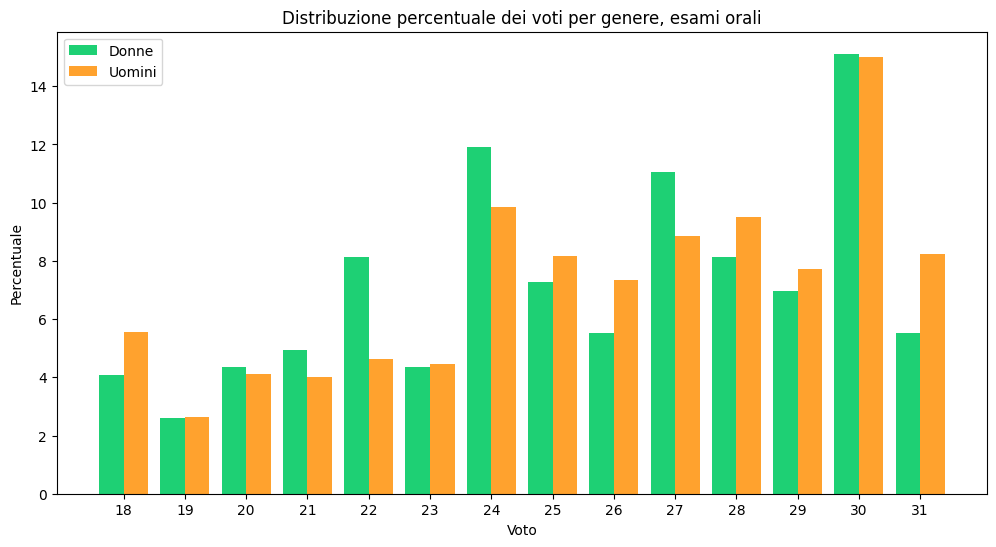

In [32]:
# distribuzione dei voti orali

totale_voti_donne = len(esami_orali[esami_orali['GENERE'] == 'F'])
totale_voti_uomini = len(esami_orali[esami_orali['GENERE'] == 'M'])
voti_donne = esami_orali[esami_orali['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esami_orali[esami_orali['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere, esami orali')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


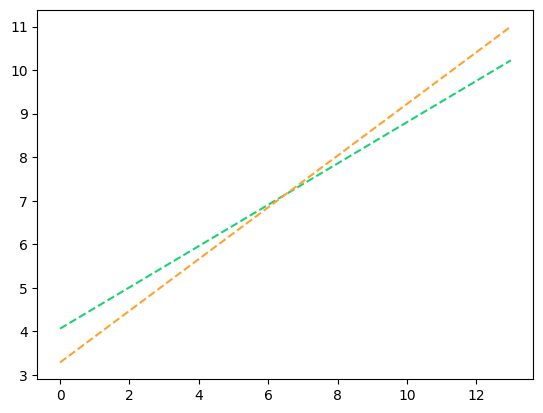

In [33]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini

plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')


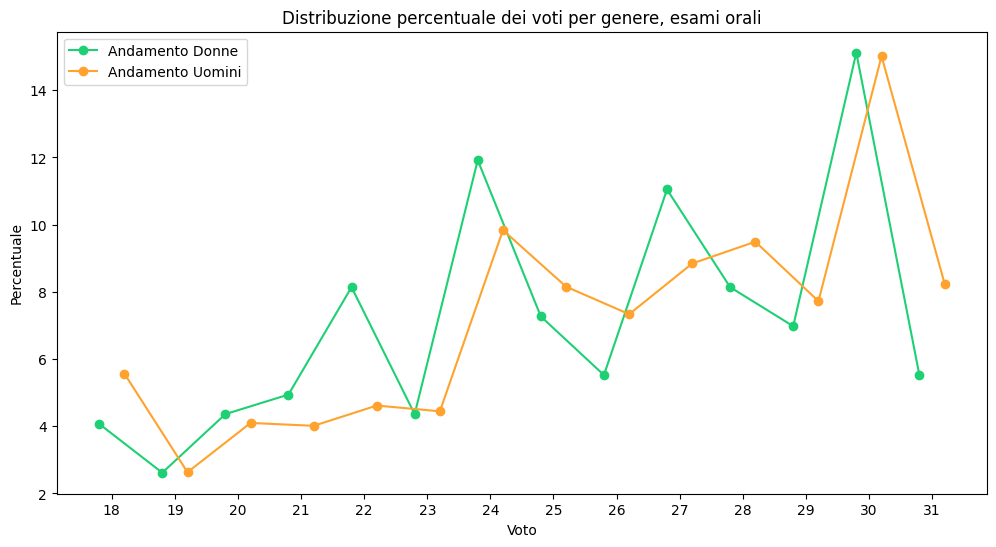

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(r1, percentuale_voti_donne, marker='o', color=colore_donne, label='Andamento Donne')
plt.plot(r2, percentuale_voti_uomini, marker='o', color=colore_uomini, label='Andamento Uomini')
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere, esami orali')
plt.legend()
plt.show()

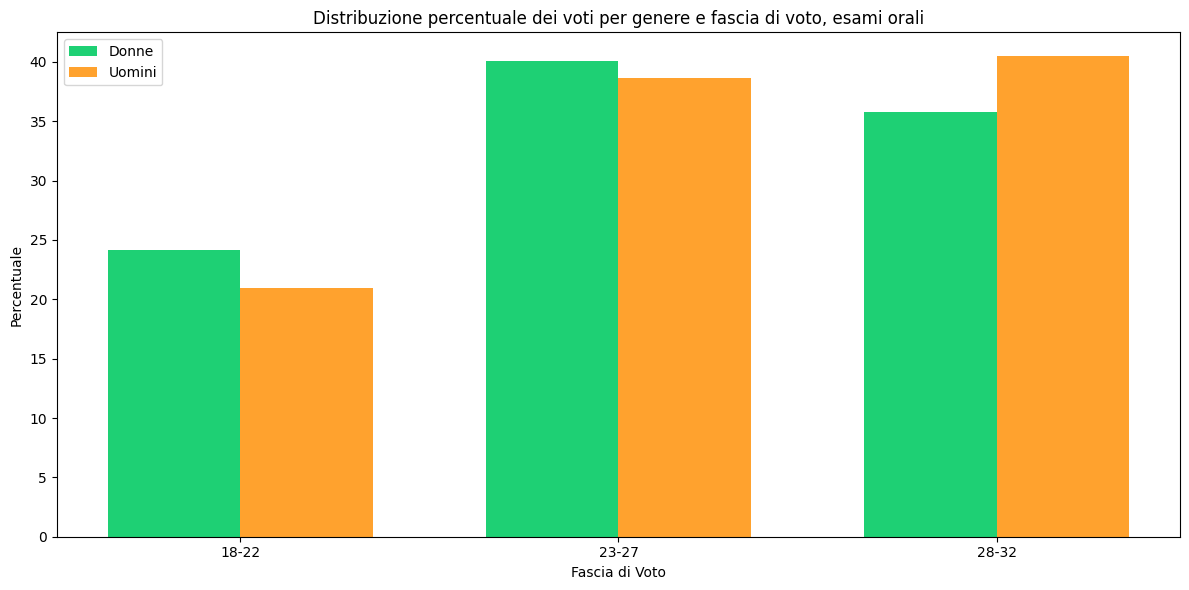

In [35]:
totale_voti = esami_orali.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto, esami orali')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


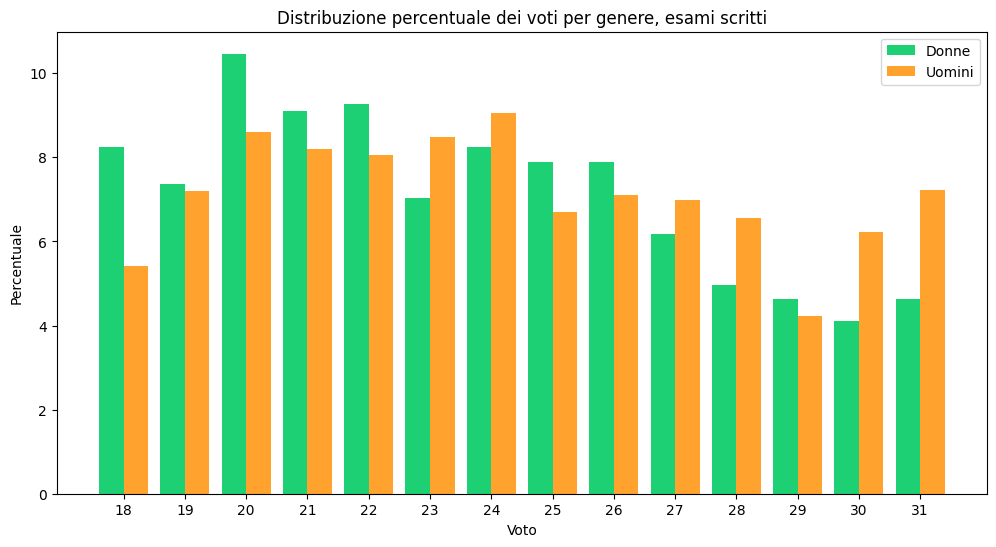

In [36]:
# distribuzione dei voti scritti

totale_voti_donne = len(esami_scritti[esami_scritti['GENERE'] == 'F'])
totale_voti_uomini = len(esami_scritti[esami_scritti['GENERE'] == 'M'])
voti_donne = esami_scritti[esami_scritti['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esami_scritti[esami_scritti['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color=colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere, esami scritti')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


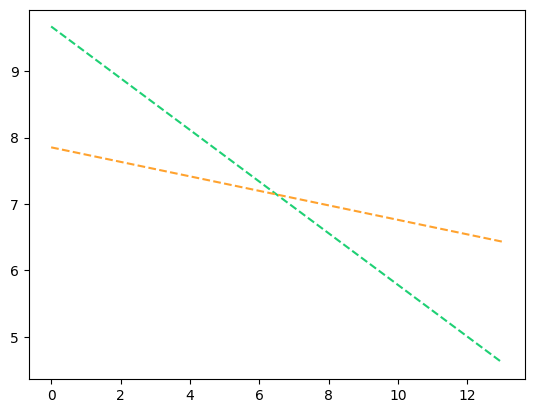

In [37]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini

plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')


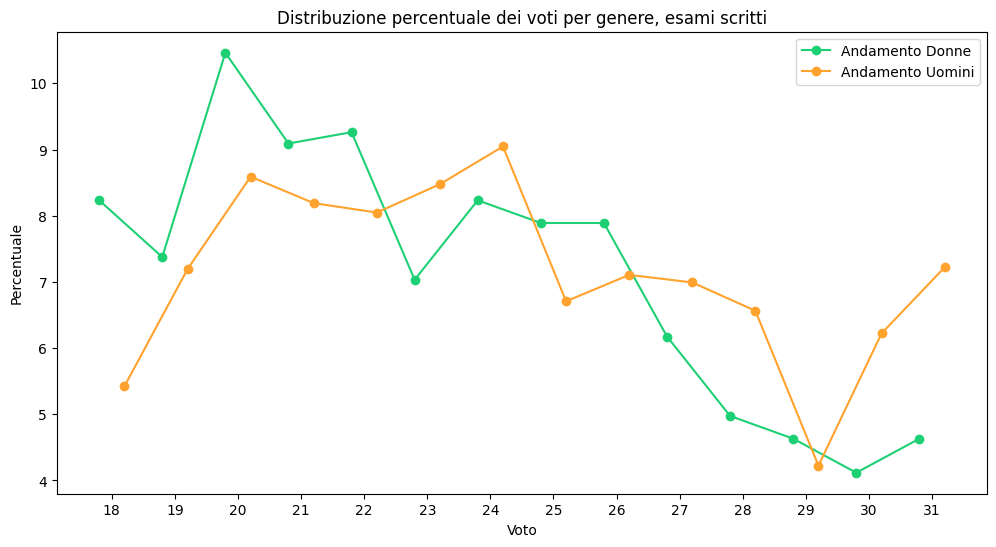

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(r1, percentuale_voti_donne, marker='o', color=colore_donne, label='Andamento Donne')
plt.plot(r2, percentuale_voti_uomini, marker='o', color=colore_uomini, label='Andamento Uomini')
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere, esami scritti')
plt.legend()
plt.show()

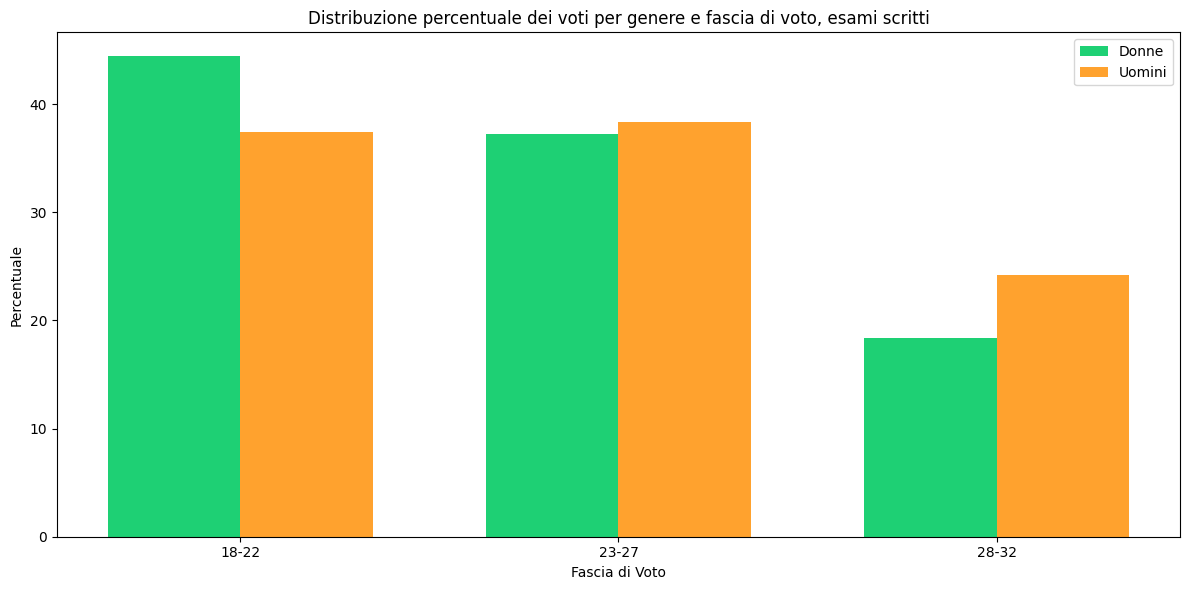

In [39]:
totale_voti = esami_scritti.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (totale_voti.loc['F'] / totale_voti.loc['F'].sum()) * 100
percentuali_uomini = (totale_voti.loc['M'] / totale_voti.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto, esami scritti')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()


### Singoli esami

In [40]:
pt['DECODIFICA_INS'].unique()

array(['ALGORITMI E STRUTTURE DATI', 'ARCHITETTURA DEI CALCOLATORI',
       'CALCULUS 1', 'INTRODUZIONE ALLA PROGRAMMAZIONE',
       'ELEMENTI DI MATEMATICA E LOGICA',
       'PERFEZIONAMENTO DELLA LINGUA INGLESE  ',
       'LINGUAGGI E PROGRAMMAZIONE ORIENTATA  AGLI OGGETTI',
       "SISTEMI DI ELABORAZIONE E TRASMISSIONE DELL'INFORMAZIONE",
       'ALGEBRA LINEARE E ANALISI NUMERICA',
       "TEORIA DELL'INFORMAZIONE E INFERENZA", 'BASI DI DATI',
       'PROGRAMMAZIONE CONCORRENTE E ALGORITMI DISTRIBUITI',
       'GESTIONE AZIENDALE', 'SVILUPPO DI APPLICAZIONI WEB',
       'BASI DI DATI 2', 'TECNICHE AVANZATE DI PROGRAMMAZIONE',
       'TEORIA DEGLI AUTOMI E CALCOLABILITÀ',
       'FONDAMENTI DI INGEGNERIA DEL SOFTWARE', 'SISTEMI ERP',
       'GEOMETRIA', 'INGEGNERIA DEL SOFTWARE (6 CFU)',
       "SISTEMI DI ELABORAZIONE DELL'INFORMAZIONE 1",
       'SISTEMI DI ELABORAZIONE E DI TRASMISSIONE',
       "FONDAMENTI DELL'INFORMATICA", 'CALCULUS 2',
       'COMPLEMENTI DI ALGORITMI E STRU

In [48]:
# CALCULUS 2
esame_singolo = pt[(pt['DECODIFICA_INS'] == "LINGUAGGI E PROGRAMMAZIONE ORIENTATA  AGLI OGGETTI")]

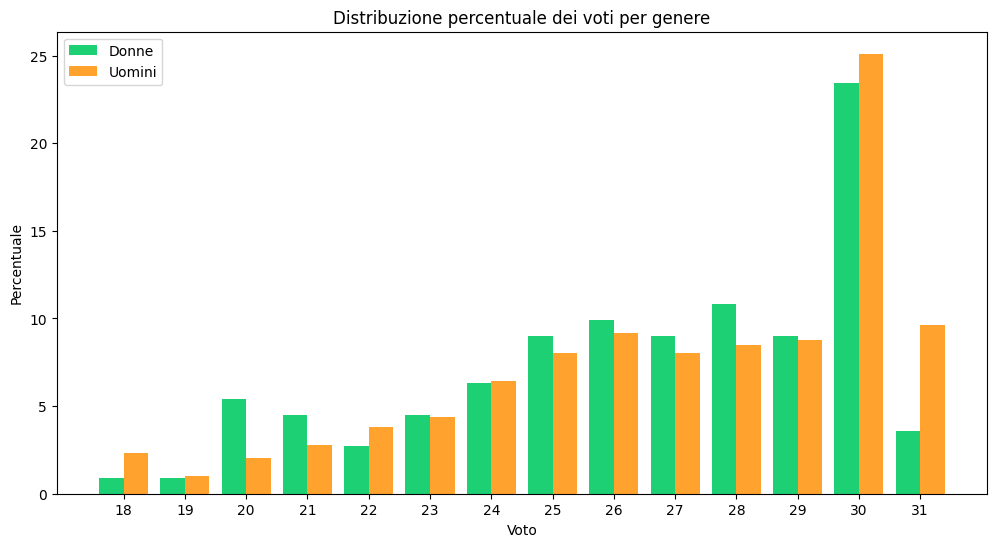

In [49]:
totale_voti_donne = len(esame_singolo[esame_singolo['GENERE'] == 'F'])
totale_voti_uomini = len(esame_singolo[esame_singolo['GENERE'] == 'M'])
voti_donne = esame_singolo[esame_singolo['GENERE'] == 'F']['VOTO'].value_counts().sort_index()
voti_uomini = esame_singolo[esame_singolo['GENERE'] == 'M']['VOTO'].value_counts().sort_index()
voti = sorted(set(voti_donne.index).union(set(voti_uomini.index)))
voti_donne = voti_donne.reindex(voti, fill_value=0)
voti_uomini = voti_uomini.reindex(voti, fill_value=0)
percentuale_voti_donne = (voti_donne / totale_voti_donne) * 100
percentuale_voti_uomini = (voti_uomini / totale_voti_uomini) * 100

bar_width = 0.4
r1 = np.arange(len(voti))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuale_voti_donne, width=bar_width, label='Donne', color= colore_donne)
plt.bar(r2, percentuale_voti_uomini, width=bar_width, label='Uomini', color=colore_uomini)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere')
plt.legend()
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)

plt.show()


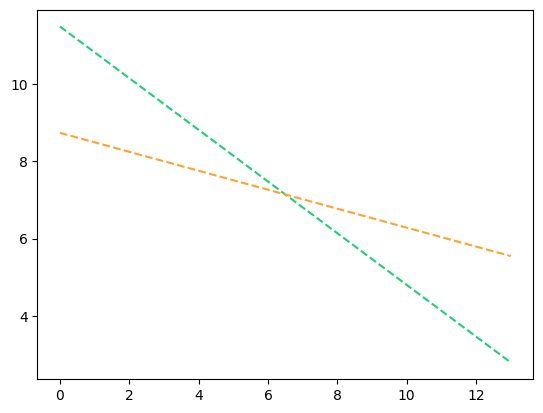

In [43]:
# regressione lineare
# donne
slope_donne, intercept_donne, _, _, _ = linregress(r1, percentuale_voti_donne)
regressione_donne = slope_donne * np.array(r1) + intercept_donne
# uomini
slope_uomini, intercept_uomini, _, _, _ = linregress(r1, percentuale_voti_uomini)
regressione_uomini = slope_uomini * np.array(r1) + intercept_uomini

plt.plot(r1, regressione_donne, label='Regressione Donne', color=colore_donne, linestyle='--')
plt.plot(r1, regressione_uomini, label='Regressione Uomini', color=colore_uomini, linestyle='--')

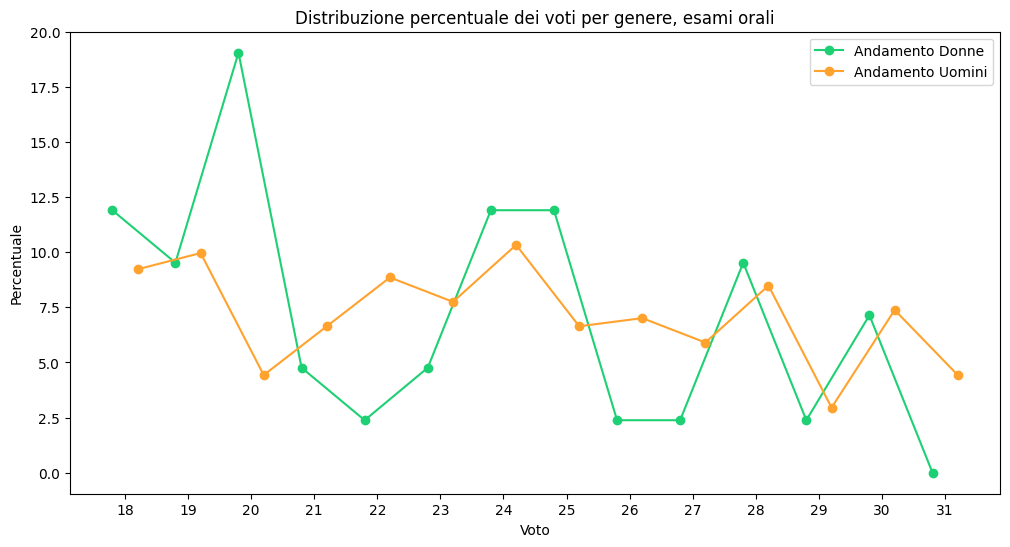

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(r1, percentuale_voti_donne, marker='o', color=colore_donne, label='Andamento Donne')
plt.plot(r2, percentuale_voti_uomini, marker='o', color=colore_uomini, label='Andamento Uomini')
plt.xticks([r + bar_width/2 for r in range(len(voti))], voti)
plt.xlabel('Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere, esami orali')
plt.legend()
plt.show()

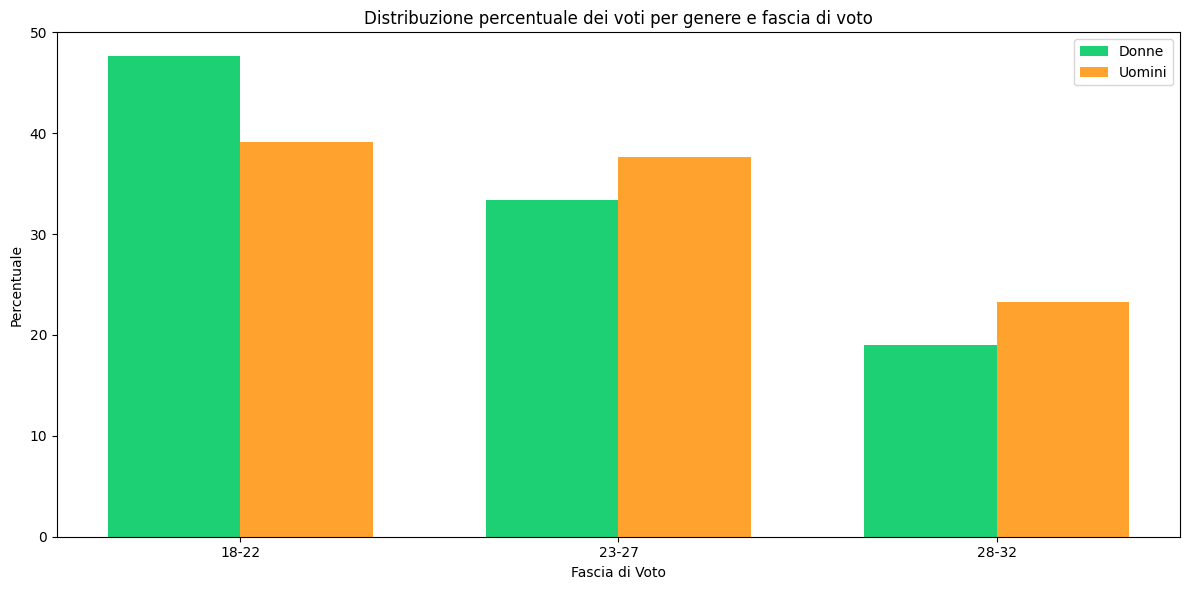

In [45]:
esame_singolo = esame_singolo.groupby(['GENERE', 'FASCIA_VOTO']).size().unstack()
percentuali_donne = (esame_singolo.loc['F'] / esame_singolo.loc['F'].sum()) * 100
percentuali_uomini = (esame_singolo.loc['M'] / esame_singolo.loc['M'].sum()) * 100

bar_width = 0.35
r1 = np.arange(len(percentuali_donne))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, percentuali_donne, label='Donne', color=colore_donne, width=bar_width)
plt.bar(r2, percentuali_uomini, label='Uomini', color=colore_uomini, width=bar_width)
plt.xlabel('Fascia di Voto')
plt.ylabel('Percentuale')
plt.title('Distribuzione percentuale dei voti per genere e fascia di voto')
plt.xticks(r1 + bar_width/2, percentuali_donne.index)
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
pt.tail()

,PROGRESSIVO,CODICE_INS,DECODIFICA_INS,CFU,DATA_ESAME,VOTO,DESCRIZIONE_VOTO,GENERE,ANAC_INGRESSO,ANAC_USCITA,DATA_LAUREA,SITUAZIONE_FINALE,VOTO_LAUREA,FASCIA_VOTO
20105,364494,109208,STRUMENTI PER LO SVILUPPO E GESTIONE DEL SOFTWARE,6.0,2024-02-02,27,ventisette,M,2021,2023,NaT,ATTIVO,NaN,23-27
20107,364494,80156,COMPUTER SECURITY,6.0,2024-04-19,23,ventitre,M,2021,2023,NaT,ATTIVO,NaN,23-27
20108,364494,80305,FONDAMENTI DI INGEGNERIA DEL SOFTWARE,6.0,2024-02-15,19,diciannove,M,2021,2023,NaT,ATTIVO,NaN,18-22
20109,364494,65704,SVILUPPO DI APPLICAZIONI WEB,6.0,2024-01-17,28,ventotto,M,2021,2023,NaT,ATTIVO,NaN,28-32
20112,364642,102406,LINGUA INGLESE 1,3.0,2021-12-17,32,idoneo,F,2021,2021,NaT,RINUNCIATARIO,NaN,28-32


In [47]:
# elimino persone iscritte dopo il 2020 perchè io ho gli iscritti sin al 2023

data_riferimento = pd.to_datetime('2020-01-01')
pt_nonrecente = pt[pt['ANAC_INGRESSO'] < data_riferimento]


TypeError: '<' not supported between instances of 'numpy.ndarray' and 'Timestamp'

In [ ]:
# percentuale laureati su studenti che hanno passato almeno un'esame
laurea = pt[pt['DATA_LAUREA'].notnull()]
n_studenti = len(pt['PROGRESSIVO'].unique())
n_studenti_laurea = len(laurea['PROGRESSIVO'].unique())
perc = round(((n_studenti_laurea / n_studenti) * 100), 2)
print(f"Laureati: {perc}%")

# percentuale donne su tutti gli studenti laureati
donne = pt[pt['GENERE'] == 'F']
laurea_donne = donne[donne['DATA_LAUREA'].notnull()]
n_laurea_donne = len(laurea_donne['PROGRESSIVO'].unique())
n_studenti_laurea = len(laurea['PROGRESSIVO'].unique())
perc = round(((n_laurea_donne / n_studenti_laurea) * 100), 2)
print(f"Donne laureate su totale laureati: {perc}%")

# percentuale donne laureate, su totale donne
donne = pt[pt['GENERE'] == 'F']
laurea = donne[donne['DATA_LAUREA'].notnull()]
n_studenti = len(donne['PROGRESSIVO'].unique())
n_studenti_laurea = len(laurea['PROGRESSIVO'].unique())
perc = round(((n_studenti_laurea / n_studenti) * 100), 2)
print(f"Percentuale donne laureate su totale donne: {perc}")

# percentuale uomini su totale uomini
uomini = pt[pt['GENERE'] == 'M']
laurea = uomini[uomini['DATA_LAUREA'].notnull()]
n_studenti = len(uomini['PROGRESSIVO'].unique())
n_studenti_laurea = len(laurea['PROGRESSIVO'].unique())
perc = round(((n_studenti_laurea / n_studenti) * 100), 2)
print(f"Percentuale uomini laureate su totale uomini: {perc}")

Laureati: 31.68%
Donne laureate su totale laureati: 13.5%
Percentuale donne laureate su totale donne: 31.36
Percentuale uomini laureate su totale uomini: 31.73


Il numero di donne è piuttosto in linea con il numero di donne che hanno passato almeno un esame, ovvero il 14%

In [ ]:
# grafici